In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
from time import time
from medmnist import PneumoniaMNIST
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter


%matplotlib inline


# pip install qiskit==0.46
# pip install qiskit_machine_learning==0.7.2
# pip install qiskit_algorithms==0.3.0
# pip install pylatexenc
# pip install medmnist
# pip install matplotlib scikit-learn

In [2]:
device = torch.device("cpu")

Using downloaded and verified file: C:\Users\quaso\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\quaso\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\quaso\.medmnist\pneumoniamnist.npz
Oversampled Training Dataset Class Distribution:
Class 1: 3494 samples
Class 0: 3494 samples
Oversampled Validation Dataset Class Distribution:
Class 1: 389 samples
Class 0: 389 samples
Test Dataset Class Distribution:
Class 1: 390 samples
Class 0: 234 samples


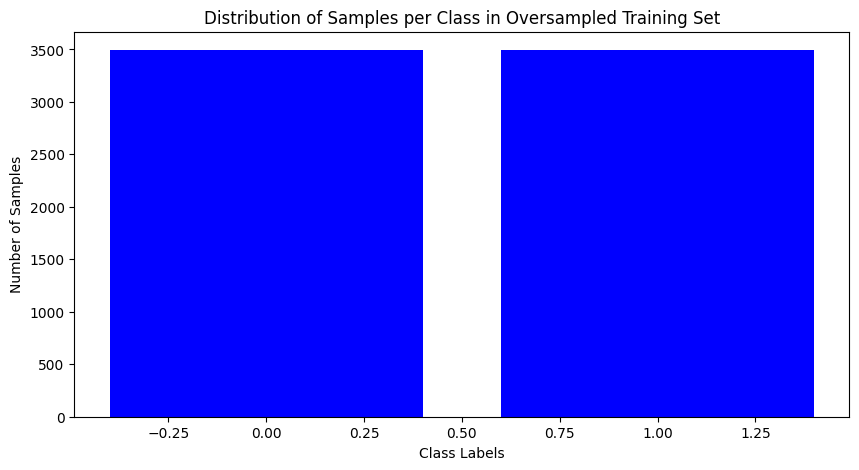

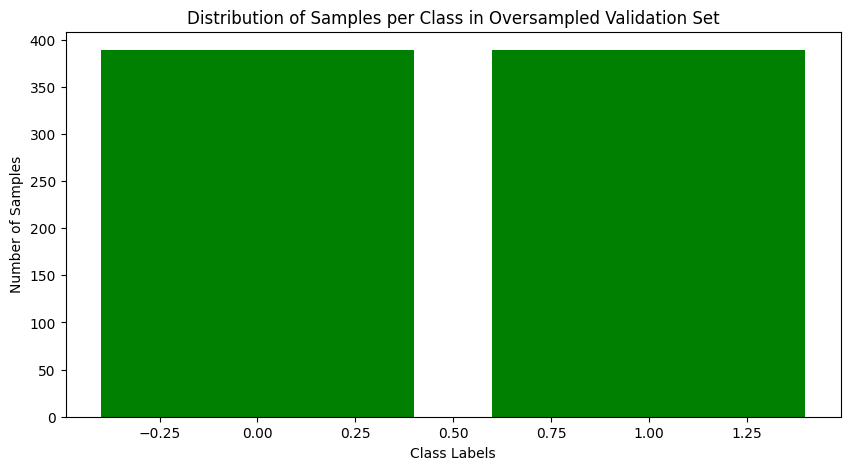

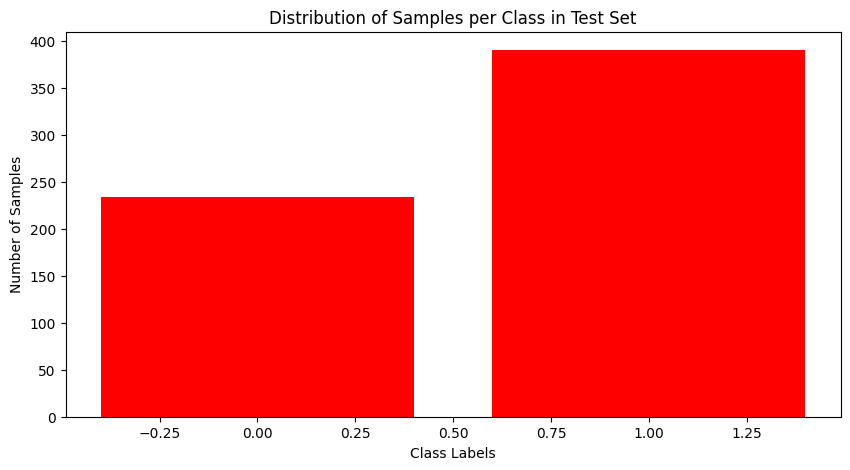

In [3]:
class OversampledDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = self.dataset.labels.flatten()
        self.data = self.dataset.imgs
        self.indices = np.arange(len(self.labels))

        # Count the number of samples per class
        self.class_counts = Counter(self.labels)
        self.max_count = max(self.class_counts.values())

        # Create new indices by oversampling the minority class
        self.oversampled_indices = self._oversample()

    def _oversample(self):
        oversampled_indices = []
        for label in self.class_counts:
            class_indices = self.indices[self.labels == label]
            oversampled_class_indices = np.random.choice(class_indices, self.max_count, replace=True)
            oversampled_indices.extend(oversampled_class_indices)
        return np.array(oversampled_indices)

    def __len__(self):
        return len(self.oversampled_indices)

    def __getitem__(self, idx):
        sample_idx = self.oversampled_indices[idx]
        sample = self.data[sample_idx]
        label = self.labels[sample_idx]
        if self.dataset.transform:
            sample = self.dataset.transform(sample)
        return sample, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to FloatTensor.
])

# Load the datasets
train_dataset = PneumoniaMNIST(split='train', download=True, size=28, transform=transform)
val_dataset = PneumoniaMNIST(split='val', download=True, size=28, transform=transform)
test_dataset = PneumoniaMNIST(split='test', download=True, size=28, transform=transform)

# Create oversampled datasets for training and validation
oversampled_train_dataset = OversampledDataset(train_dataset)
oversampled_val_dataset = OversampledDataset(val_dataset)

# Create DataLoaders
trainloader = DataLoader(oversampled_train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(oversampled_val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the class distribution after oversampling
def verify_class_distribution(dataloader):
    label_counts = Counter()
    for data, target in dataloader:
        labels = target.numpy().flatten().tolist()
        label_counts.update(labels)
    return dict(label_counts)

train_label_counts = verify_class_distribution(trainloader)
val_label_counts = verify_class_distribution(valloader)
test_label_counts = verify_class_distribution(testloader)

print("Oversampled Training Dataset Class Distribution:")
for label, count in train_label_counts.items():
    print(f"Class {label}: {count} samples")

print("Oversampled Validation Dataset Class Distribution:")
for label, count in val_label_counts.items():
    print(f"Class {label}: {count} samples")

print("Test Dataset Class Distribution:")
for label, count in test_label_counts.items():
    print(f"Class {label}: {count} samples")

# Plot the distribution of classes for the training set
labels = list(train_label_counts.keys())
counts = list(train_label_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='blue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class in Oversampled Training Set')
plt.show()

# Plot the distribution of classes for the validation set
labels = list(val_label_counts.keys())
counts = list(val_label_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='green')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class in Oversampled Validation Set')
plt.show()

# Plot the distribution of classes for the test set
labels = list(test_label_counts.keys())
counts = list(test_label_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='red')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class in Test Set')
plt.show()


torch.Size([64, 1, 28, 28])
torch.Size([64])


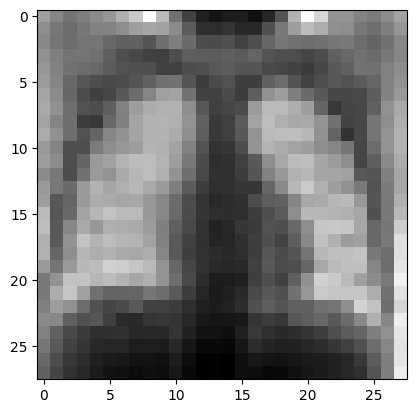

In [4]:

# def preprocess(trainset):
#     labels = trainset.targets
#     labels = labels.numpy()
#     index1 = np.where(labels == 0) # filter 0's
#     index2 = np.where(labels == 1) # filter on 1's
#     n=200 # Number of datapoints per class 
#     index = np.concatenate((index1[0][0:n],index2[0][0:n])) 
#     trainset.targets = labels[index] 
#     trainset.data = trainset.data[index]
#     return trainset

# #converts the image into tensors
# # transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

# # Define transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to FloatTensor.
#     # Normalize(mean, std) if required, e.g., transforms.Normalize((0.5,), (0.5,))
# ])


# # trainset = datasets.MNIST(root='./mnistdata', train=True, download=True, transform=transform)
# train_dataset = PneumoniaMNIST(split='train', download=True, size=28, transform=transform)
# val_dataset = PneumoniaMNIST(split='val', download=True, size=28, transform=transform)
# test_dataset = PneumoniaMNIST(split='test', download=True, size=28, transform=transform)


# # trainloader = torch.utils.data.DataLoader(preprocess(trainset), batch_size=1, shuffle=True)
# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [5]:
# # Count the number of samples per class in the training set
# import matplotlib.pyplot as plt
# from collections import Counter

# # Initialize the counter
# label_counts = Counter()

# # Iterate over the training dataset to count the number of samples per class
# for data, target in trainloader:
#     labels = target.numpy().flatten().tolist()  # Convert to a flattened list
#     label_counts.update(labels)

# # Convert the counter to a dictionary for easier manipulation
# label_counts = dict(label_counts)

# # Print the number of samples for each class
# for label, count in label_counts.items():
#     print(f"Class {label}: {count} samples")

# # Plot the distribution of classes
# labels = list(label_counts.keys())
# counts = list(label_counts.values())

# plt.figure(figsize=(10, 5))
# plt.bar(labels, counts, color='blue')
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Samples')
# plt.title('Distribution of Samples per Class in Training Set')
# plt.show()


In [6]:
def to_numbers(tensor_list):
    list = []
    for tensor in tensor_list:
        list += [tensor.item()]
    return list

In [7]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import circuit_drawer
import numpy as np

class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    def __init__(self, shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1, 'q')
            cr = ClassicalRegister(1, 'c')
            ckt = QuantumCircuit(qr, cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta, qr[0])
            ckt.barrier()
            ckt.measure(qr, cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key] / shots
            check = np.array([(float(key[i]) - 1/2) * 2 * perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit, backend, shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, 1)

    def draw_circuit(self, filename="circuit.png"):
        # Use Matplotlib to draw the circuit
        circuit_drawer(self.circuit, output='mpl', filename=filename)

# Helper function to convert parameters to numbers
def to_numbers(parameters):
    return [float(p) for p in parameters]

# Example usage:
qiskit_circuit = QiskitCircuit(shots=1024)
qiskit_circuit.draw_circuit("circuit.png")


d:\qiskit\qiskit_env\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [9]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()
qc = TorchCircuit.apply 

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.h1 = nn.Linear(320, 50)
#         self.h2 = nn.Linear(50, 1)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.h1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.h2(x)
#         x = qc(x)
#         x = (x+1)/2  # Normalise the inputs to 1 or 0
#         x = torch.cat((x, 1-x), -1)
#         return x
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)  # Assuming binary classification

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Apply log_softmax for nll_loss
    
# Example usage:
network = Net().to(device)
print(network)




Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [10]:
# # Define your network
# network = Net()
# network = Net().to(device)
# optimizer = optim.SGD(network.parameters(), lr=0.003, momentum=0.9)
# epochs = 30
# time0 = time()
# loss_list = []
# accuracy_list = []


# # Assume preprocess and trainloader are properly defined
# # Inside your training loop
# for epoch in range(epochs):
#     total_loss = []
#     correct = 0
#     total = 0
#     for batch_idx, (data, target) in enumerate(trainloader):
#         data, target = data.to(device), target.to(device)

#         # Check and reshape target tensor if necessary
#         if target.dim() > 1:
#             target = target.squeeze()  # Remove singleton dimensions
#         if target.dim() != 1:
#             raise ValueError("Target tensor should be 1D")

#         # Ensure target is of type long
#         target = target.long()

#         optimizer.zero_grad()
#         output = network(data)

#         # Compute the loss
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         total_loss.append(loss.item())

#         # Calculate accuracy
#         _, predicted = torch.max(output.data, 1)
#         total += target.size(0)
#         correct += (predicted == target).sum().item()

#     loss_list.append(sum(total_loss) / len(total_loss))
#     accuracy = 100 * correct / total
#     accuracy_list.append(accuracy)
#     print(f"Epoch {epoch+1}, Loss: {loss_list[-1]:.2f}, Accuracy: {accuracy:.2f}%")


# print(f"Training finished, took {time() - time0:.2f}s")


In [11]:
# def calculate_accuracy(data_loader, model, device):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data, target in data_loader:
#             data, target = data.to(device), target.to(device)
#             outputs = model(data)
#             _, predicted = torch.max(outputs, 1)
#             total += target.size(0)
#             correct += (predicted == target).sum().item()

#             # Debugging outputs
#             print("Outputs:", outputs)
#             print("Predicted:", predicted)
#             print("Actual:", target)
#             print("Correct predictions per batch:", (predicted == target).sum().item())
#             print("Running total correct:", correct)
#             print("Running total samples:", total)

#     accuracy = 100 * correct / total
#     print("Total correct:", correct)
#     print("Total samples:", total)
#     return accuracy

# # Set the network to evaluation mode
# network.eval()
# val_accuracy = calculate_accuracy(valloader, network, device)
# test_accuracy = calculate_accuracy(testloader, network, device)
# print(f"Validation Accuracy: {val_accuracy:.2f}%")
# print(f"Test Accuracy: {test_accuracy:.2f}%")


In [12]:
def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    loss = 0
    criterion = nn.NLLLoss()

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Check and reshape target tensor if necessary
            if target.dim() > 1:
                target = target.squeeze()  # Remove singleton dimensions
            if target.dim() != 1:
                raise ValueError("Target tensor should be 1D")

            # Ensure target is of type long
            target = target.long()

            output = model(data)
            loss += criterion(output, target).item()

            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [13]:
# Define the network, optimizer, and training parameters
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=0.003, momentum=0.9)
epochs = 30
time0 = time()
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(epochs):
    network.train()  # Set the model to training mode
    total_loss = []
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        # Check and reshape target tensor if necessary
        if target.dim() > 1:
            target = target.squeeze()  # Remove singleton dimensions
        if target.dim() != 1:
            raise ValueError("Target tensor should be 1D")

        # Ensure target is of type long
        target = target.long()

        optimizer.zero_grad()
        output = network(data)

        # Compute the loss
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_train_loss = sum(total_loss) / len(total_loss)
    train_accuracy = 100 * correct / total
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(network, valloader, device)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}%")

print(f"Training finished, took {time() - time0:.2f}s")


Epoch 1, Train Loss: 0.69, Train Accuracy: 52.48%, Val Loss: 0.69, Val Accuracy: 62.47%
Epoch 2, Train Loss: 0.68, Train Accuracy: 60.56%, Val Loss: 0.66, Val Accuracy: 85.86%
Epoch 3, Train Loss: 0.64, Train Accuracy: 69.06%, Val Loss: 0.55, Val Accuracy: 85.73%
Epoch 4, Train Loss: 0.48, Train Accuracy: 79.97%, Val Loss: 0.32, Val Accuracy: 89.07%
Epoch 5, Train Loss: 0.36, Train Accuracy: 85.73%, Val Loss: 0.31, Val Accuracy: 85.73%
Epoch 6, Train Loss: 0.33, Train Accuracy: 87.34%, Val Loss: 0.24, Val Accuracy: 91.26%
Epoch 7, Train Loss: 0.30, Train Accuracy: 89.21%, Val Loss: 0.21, Val Accuracy: 92.29%
Epoch 8, Train Loss: 0.29, Train Accuracy: 89.01%, Val Loss: 0.21, Val Accuracy: 91.39%
Epoch 9, Train Loss: 0.27, Train Accuracy: 89.22%, Val Loss: 0.21, Val Accuracy: 94.09%
Epoch 10, Train Loss: 0.27, Train Accuracy: 89.65%, Val Loss: 0.19, Val Accuracy: 93.19%
Epoch 11, Train Loss: 0.26, Train Accuracy: 89.51%, Val Loss: 0.18, Val Accuracy: 91.65%
Epoch 12, Train Loss: 0.24, Tr

In [14]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")
    return total_params

# Example usage:
count_parameters(network)


Total number of parameters: 21432


21432

In [15]:
# Evaluate on test set
test_loss, test_accuracy = evaluate(network, testloader, device)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.45, Test Accuracy: 85.42%


In [16]:
print("Output shape:", output.shape)
print("Output dtype:", output.dtype)
print("Target shape:", target.shape)
print("Target dtype:", target.dtype)

Output shape: torch.Size([12, 2])
Output dtype: torch.float32
Target shape: torch.Size([12])
Target dtype: torch.int64


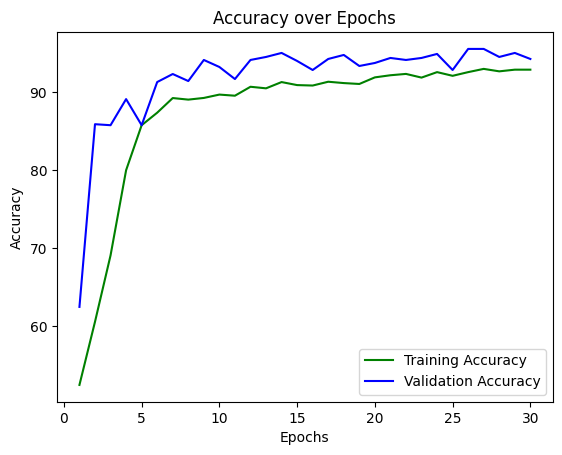

In [17]:
# Optionally plot the accuracy over epochs
plt.figure()
plt.plot(range(1, epochs+1), train_accuracy_list, 'g-', label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy_list, 'b-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [18]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Check and reshape target tensor if necessary
            if target.dim() > 1:
                target = target.squeeze()  # Remove singleton dimensions
            if target.dim() != 1:
                raise ValueError("Target tensor should be 1D")

            # Ensure target is of type long
            target = target.long()

            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


Test Loss: 0.45, Test Accuracy: 85.42%


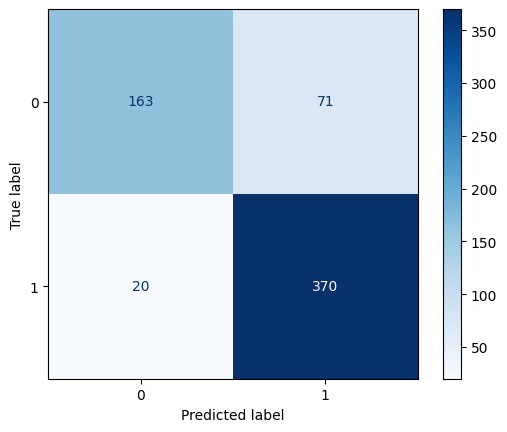

In [19]:
test_loss, test_accuracy = evaluate(network, testloader, device)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot confusion matrix
plot_confusion_matrix(network, testloader, device)


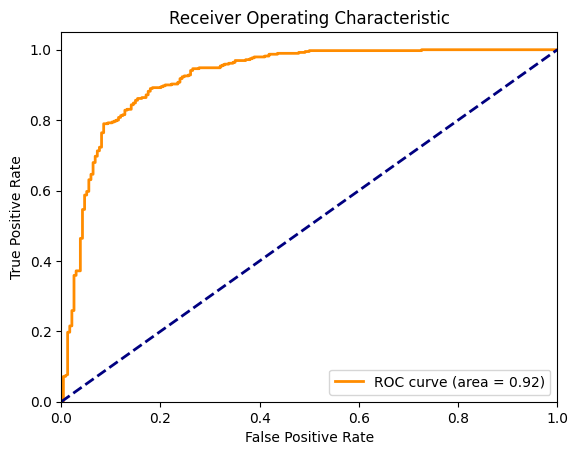

In [20]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Check and reshape target tensor if necessary
            if target.dim() > 1:
                target = target.squeeze()  # Remove singleton dimensions
            if target.dim() != 1:
                raise ValueError("Target tensor should be 1D")

            # Ensure target is of type long
            target = target.long()

            output = model(data)
            all_preds.extend(output[:, 1].cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(network, testloader, device)

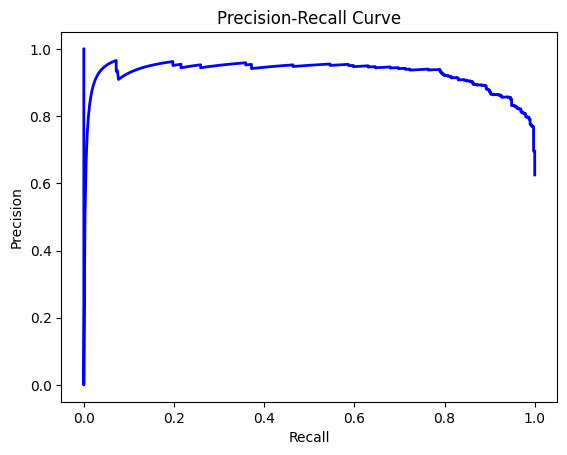

In [21]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, dataloader, device):
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Check and reshape target tensor if necessary
            if target.dim() > 1:
                target = target.squeeze()  # Remove singleton dimensions
            if target.dim() != 1:
                raise ValueError("Target tensor should be 1D")
            target = target.long()

            output = model(data)
            all_preds.extend(output[:, 1].cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
plot_precision_recall_curve(network, testloader, device)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    loss = 0
    criterion = nn.NLLLoss()

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Check and reshape target tensor if necessary
            if target.dim() > 1:
                target = target.squeeze()  # Remove singleton dimensions
            if target.dim() != 1:
                raise ValueError("Target tensor should be 1D")

            # Ensure target is of type long
            target = target.long()

            output = model(data)
            loss += criterion(output, target).item()

            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    avg_loss = loss / len(dataloader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return avg_loss, accuracy, precision, recall, f1

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(network, testloader, device)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.45, Test Accuracy: 85.42%


In [23]:
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")


Test Precision: 0.84
Test Recall: 0.95
Test F1 Score: 0.89
